# Progress Task 1: Prediction of wine quality

# Introduction

This progress task has the aim to predict the quality of wine based on its physicochemical properties. The dataset used in this task is the [Wine Quality Dataset](https://archive.ics.uci.edu/dataset/186/wine+quality) from the UCI Machine Learning Repository. Credits to *P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.*

The objective of this task is to select an apropiate regression and classification model and compare them.

## Prepare environmental variables

Download the dataset and import the necessary packages.

In [11]:
%pip install ucimlrepo seaborn matplotlib scikit-learn pandas numpy

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
from ucimlrepo import fetch_ucirepo 
 
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
 
# data (as pandas dataframes) 
X = wine_quality.data.features 
y = wine_quality.data.targets 

df_wine = pd.concat([X,y], axis=1)
 
# metadata 
print(wine_quality.metadata) 

# get variable information 
print(wine_quality.variables)

{'uci_id': 186, 'name': 'Wine Quality', 'repository_url': 'https://archive.ics.uci.edu/dataset/186/wine+quality', 'data_url': 'https://archive.ics.uci.edu/static/public/186/data.csv', 'abstract': 'Two datasets are included, related to red and white vinho verde wine samples, from the north of Portugal. The goal is to model wine quality based on physicochemical tests (see [Cortez et al., 2009], http://www3.dsi.uminho.pt/pcortez/wine/).', 'area': 'Business', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Multivariate'], 'num_instances': 4898, 'num_features': 11, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['quality'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2009, 'last_updated': 'Wed Nov 15 2023', 'dataset_doi': '10.24432/C56S3T', 'creators': ['Paulo Cortez', 'A. Cerdeira', 'F. Almeida', 'T. Matos', 'J. Reis'], 'intro_paper': {'ID': 252, 'type': 'NATIVE', 'title': 'Modeling wine preferences

## Exploratory Data Analysis (EDA)

In this section, a brief exploratory data analysis (EDA) will be performed on the dataset, prior to correctly pre-process it and capture the most relevant features for model training.

### Describing the dataset

In [4]:
# Check the number of instances and the number of features
print ("Shape of data:", X.shape , y.shape)

Shape of data: (6497, 11) (6497, 1)


In [5]:
# Print the first rows of the features
print("=================== Feature's First Rows ===================\n", X.head(3), "\n")

# Print the first rows of the target
print("=================== Target's First Rows ===================\n", y.head(3), "\n")

=================== Feature's First Rows ===================
    fixed_acidity  volatile_acidity  citric_acid  ...    pH  sulphates  alcohol
0            7.4              0.70         0.00  ...  3.51       0.56      9.4
1            7.8              0.88         0.00  ...  3.20       0.68      9.8
2            7.8              0.76         0.04  ...  3.26       0.65      9.8

[3 rows x 11 columns] 

=================== Target's First Rows ===================
    quality
0        5
1        5
2        5 



In [6]:
# Check for missing values
print("=================== Null value count ===================\n",df_wine.isnull().sum(), "\n")

=================== Null value count ===================
 fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64 



In [7]:
df_wine.describe(percentiles=[])

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


Now that we have taken a look into the dataset, here's a summary:

The dataset consists of 11 continuous features, none of them with missing values. The features are: 

* `fixed_acidity`: with values ranging from 4.6 to 15.9.
* `volatile_acidity`: with values ranging from 0.12 to 1.58.
* `citric_acid`: with values ranging from 0 to 1.66.
* `residual_sugar`: with values ranging from 0.6 to 65.8.
* `chlorides`: with values ranging from 0.009 to 0.611.
* `free_sulfur_dioxide`: with values ranging from 1 to 289.
* `total_sulfur_dioxide`: with values ranging from 6 to 440.
* `density`: with values ranging from 0.99 to 1.003.
* `pH`: with values ranging from 2.74 to 4.01.
* `sulphates`: with values ranging from 0.33 to 2.
* `alcohol`: with values ranging from 8.4 to 14.9.

The target variable is:
* `quality`: is an integer variable, from 0 to 10 but in this dataset it ranges from 3 to 9.

Now that the statistical summary of the dataset has been obtained, a pairplot will be created to visualize the relationships between the features and the target variable.

### Descriptive statistics

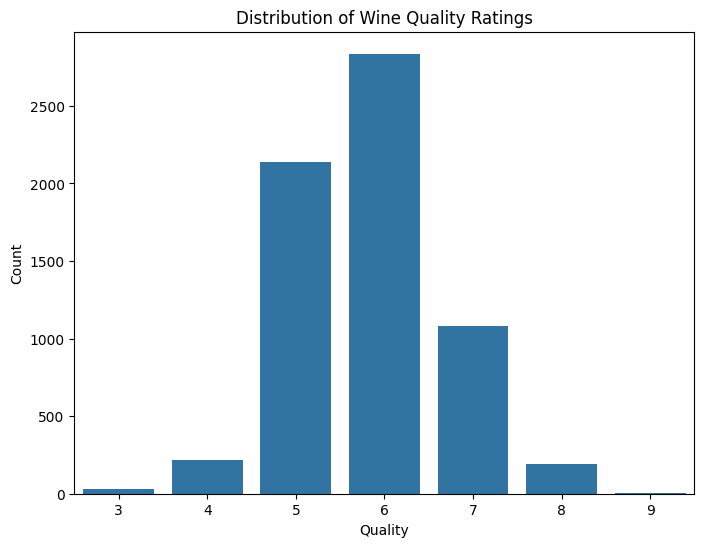

In [24]:
plt.figure(figsize=(8, 6))
sns.countplot(x='quality', data=df_wine)
plt.title("Distribution of Wine Quality Ratings")
plt.xlabel("Quality")
plt.ylabel("Count")
plt.show()

As shown in the plot, the target variable `quality` is not a balanced set. The majority of the wines have a quality of 5 or 6, with a few wines having a quality of 3 or 9. 

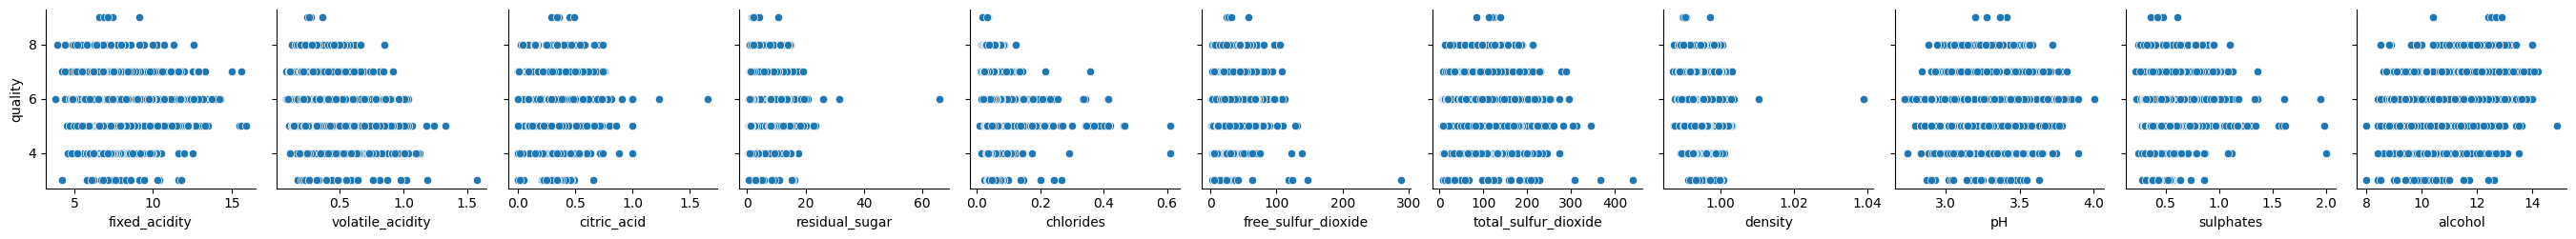

In [12]:
sns.pairplot(df_wine, y_vars='quality',x_vars=df_wine.columns[:-1])
plt.show()

From the pairplot, a strange data distribution can be observed. All the instances seem to be grouped by a certain value of the variable `quality`. The reason for this is that the target variable is **discrete**, so **it is treated as a categorical variable**.

Given that no direct relation with the target can be inferred from the pairplot, the next step is to create pairplots between every pair of features. Then, the dependencies between the features will be analyzed.

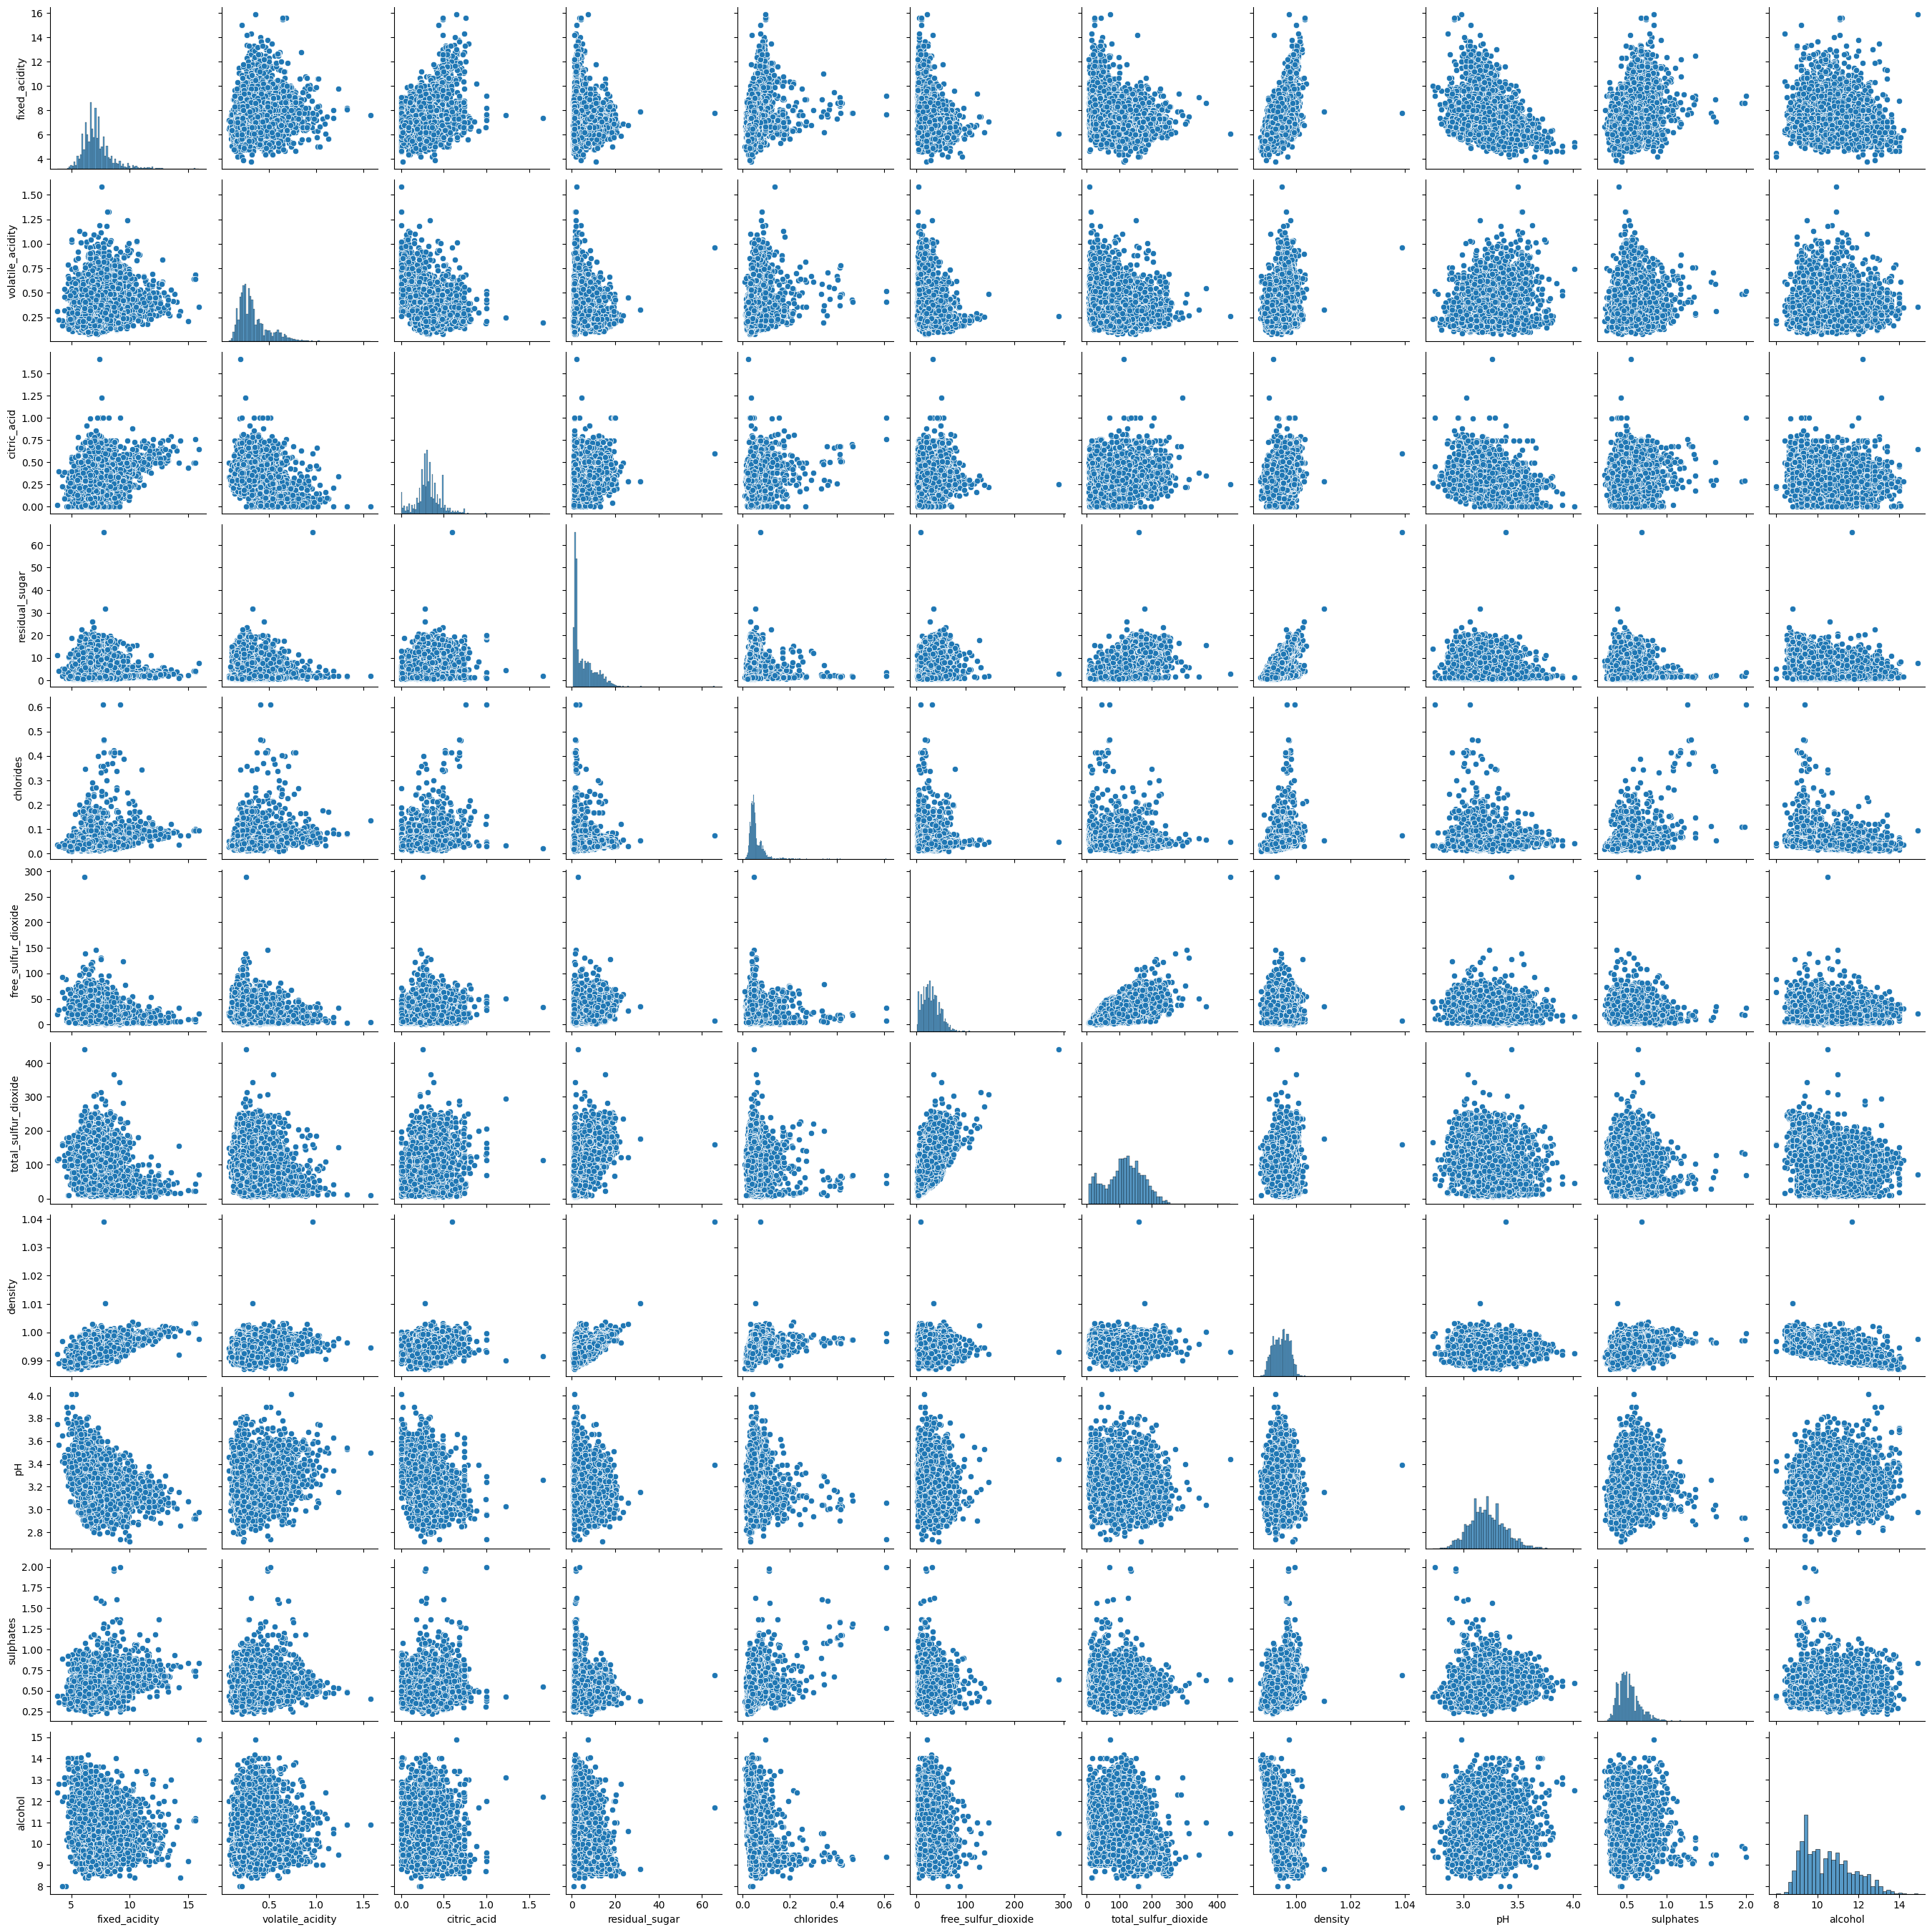

In [ ]:
sns.pairplot(data = X)
plt.show()

From the pairplot there are some interesting observations: 

- Fixed acidity and density seem to have a linear relationship. 
- Density seems to have a horizontal line pattern with other features, that could represent a constant value.

From there, valueable information cannot be extracted, so it is necessary to continue analyzing the dataset. 

<Axes: >

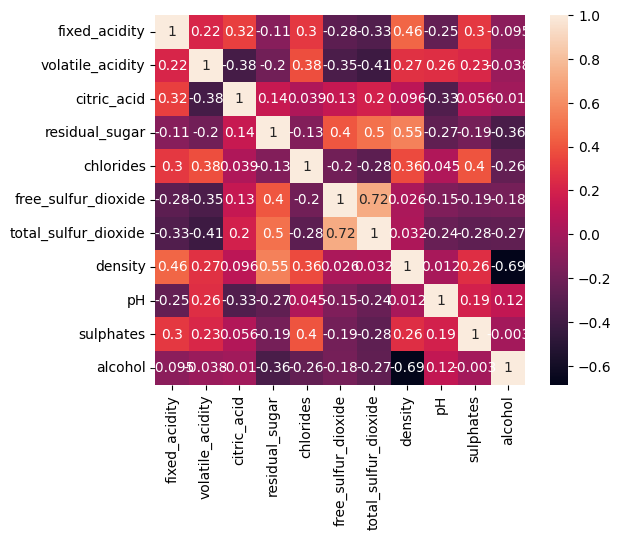

In [14]:
# Correlation matrix
corrmat = X.corr()
sns.heatmap(corrmat, square = True, annot=True)

Out from the plot, the strongest correlation can be observed between the attributes **`free_sulfur_dioxide`** and **`total_sulfur_dioxide`** (0.72). The reason for this is total sulfur dioxide includes the free sulfur dioxide, so the variable free sulfur will be removed from the dataset, as both variables represent almost the same information and this will reduce redundancy.

The second strongest correlation is between **`density`** and **`alcohol`** (-0.69). This correlation is negative, due to the fact that an increase in the alcohol graduation in wine leads to a loss of water quantity. Therefore, given that alcohol is less dense than water, the density of the wine decreases.

maybe test to remove density as it might be a constant value?

In [ ]:
df_wine.drop(columns=['free_sulfur_dioxide'], inplace=True)
X.drop(columns=['free_sulfur_dioxide'], inplace=True)

## Performance evaluation of regression models

We will put here the different model evaluations

### Simple Linear Regression

Simple linear regression assumes the dependency of Y on X (or $X_1$, $X_2$, ... , $X_n$) is linear. In simple linear regression, we have a single predictor X. Mathematically, we can write this linear relationship as: $Y = \beta_0 + \beta_1X + \epsilon$.

Let's plot again the pairplot with all the features and the target variable.

In [ ]:
sns.pairplot(df_wine, y_vars='quality',x_vars=df_wine.columns[:-1])
plt.show()

As we can see, a line cannot be drawn to represent the relationship between the features and the target variable. This is because the target variable is discrete. However, let's try to fit a simple linear regression model for each feature.

In [ ]:
from sklearn.linear_model import LinearRegression

In [ ]:
plt.figure(figsize=(20, 15))
y = df_wine['quality']
for i, feature in enumerate(df_wine.columns[:-1]):
    plt.subplot(4, 3, i + 1)
    linear = LinearRegression()
    X = df_wine[[feature]]  # Reshape to 2D array
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    linear.fit(X_train, y_train)
    y_pred = linear.predict(X_test)
    plt.scatter(X_test, y_test)
    plt.plot(X_test, y_pred, color='red')
    plt.title(f"{feature} {r2_score(y_test, y_pred)}")
plt.tight_layout()
plt.show()

The results shows, what we expected. That a simple linear regression model cannot be used to predict the quality of the wine that is a discrete variable.

The highest $R^2$ score is 0.18, for the feature alcohol, which is very low. The rest are close to 0.

**Conclusion**: Can't use simple linear regression.

### Multilinear Regression

#### Multilinear Regression - Ridge criterion

The following block of code will make the preparations for a multilinear regression model using the Ridge criterion. The model will be trained and evaluated using the dataset. Firstly, the train-test division will be performed, then the model will be trained and evaluated following a cross validation factor of 5.

In [ ]:
# Make the Train-Test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train data shape: ", X_train.shape, y_train.shape)

print("Test data shape: ", X_test.shape, y_test.shape)

# Create the Ridge Multilinear Regression model. We will

ridge_regressor = RidgeCV(cv=5)

# Fit the model
ridge_regressor.fit(X_train, y_train)

Train data shape:  (5197, 11) (5197, 1)
Test data shape:  (1300, 11) (1300, 1)


RidgeCV(cv=5)

The regression model has been successfully trained. Now, some metrics will be extracted from it:
As we can see, a line cannot be drawn to represent the relationship between the features and the target variable. This is because the target variable is discrete. However, let's try to fit a simple linear regression model for each feature.

In [6]:
# Best lambda (alpha) selected by cross-validation
best_lambda = ridge_regressor.alpha_
print(f"Best lambda selected by RidgeCV: {best_lambda}")

Best lambda selected by RidgeCV: 0.1


Finally, the model is tested on the test set and is evaluated by the following metrics:

- Mean Squares Error (MAE)
- R² score

In [ ]:

# Predict on the training and testing sets
y_train_pred = ridge_regressor.predict(X_train)
y_test_pred = ridge_regressor.predict(X_test)

# Calculate both Mean Squared Error and R2 Score
train_mse_ridge = mean_squared_error(y_train, y_train_pred)
test_mse_ridge = mean_squared_error(y_test, y_test_pred)

train_r2_ridge = r2_score(y_train, y_train_pred)
test_r2_ridge = r2_score(y_test, y_test_pred)

print(f"Train MSE: {train_mse_ridge}")
print(f"Test MSE: {test_mse_ridge}")
print(f"Train R2: {train_r2_ridge}")
print(f"Test R2: {test_r2_ridge}")



Train MSE: 0.5403392718721161
Test MSE: 0.5469726123572165
Train R2: 0.29676625444532223
Test R2: 0.25939337537680274


**Conclusion:** The model has not a good performance, the MSE is high and the R² score is low. This means that the model is not able to accurately predict the quality of the wine based on the physicochemical properties. This may be due to the fact that the target variable is discrete and not continuous, so a classification approach may be more suitable for this problem.

#### Multilienar Regression - Lasso criterion

### Polynomial Regression

### Decision Tree Regression

### Random Forest Regressor

### Generative Additive Models (GAMs)

### Final decision

Here we mention the best model.

## Performance evaluation of classification models

We will put here the different model evaluations

### Naïve Bayes

#### Gaussian Naïve Bayes

#### Multinomial Naïve Bayes

### Decision Trees

#### Using Entropy as criterion

#### Using Gini Index as criterion

#### Using Knowledge Gain as criterion

### Random Forest Classifier

### KNN (K-Nearest Neighbors) "Lazy Learner"

### Final decision

Here we mention the best model.